In [2]:
import os
import tqdm
import json
import math
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

In [ ]:
def get_dataset(data_dir, batch_size):
    data_transforms = {
        'train': transforms.Compose([
          transforms.RandomResizedCrop((224, 224)),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                      for x in ['train', 'val', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=1)
                  for x in ['train', 'val', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
    class_names = image_datasets['train'].classes
    
    return dataloaders, dataset_sizes, class_names


def build_model(class_num, device):
    model = models.resnet50(pretrained=True)
    num_in = model.fc.in_features
    model.fc = nn.Linear(num_in, class_num)
    model = model.to(device)
    
    return model


def train(model, epoch_num, dataloaders, data_sizes, batch_size, optimizer, criterion, scheduler, device):
    process = tqdm.notebook.tqdm(range(epoch_num))
    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

    epoch_loss = 1.0
    epoch_acc = 0.0
    for epoch in process:
        process.set_description(f'Epoch {epoch+1} / {epoch_num}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data_loader = dataloaders['train']
            else:
                model.eval()   # Set model to evaluate mode
                data_loader = dataloaders['val']

            data_size = data_sizes[phase]
            total_steps = len(data_loader)
            running_loss = 0.0
            running_corrects = 0
            steps = 0

            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
        
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
        
                # statistics
                loss_item = loss.item() * inputs.size(0)
                running_loss += loss_item
                acc_item = torch.sum(preds == labels.data)
                running_corrects += acc_item
                steps += 1
                process.set_description(f'{phase} Step:{steps}/{total_steps} Running_Loss:{loss_item:.4f} Running_Acc:{acc_item / float(batch_size):.4f} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
                if phase == 'train':
                    scheduler.step()

            epoch_loss = running_loss / data_size
            epoch_acc = running_corrects.double() / data_size
            process.set_description(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
            else:
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
    return model, history


def save_model_history(save_folder, model, history):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    
    model_path = os.path.join(save_folder, 'model.h5')
    history_path = os.path.join(save_folder, 'history.json')
    torch.save(model.state_dict(), model_path)
    with open(history_path, 'w') as f:
        json.dump(history, f)
        
        
def test_model(model, data_loader, data_size, batch_size, criterion, device):
    process = tqdm.notebook.tqdm(data_loader)
    total_acc = 0.0
    total_loss = 0.0
    for inputs, labels in process:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        loss_item = loss.item()  # per image
        total_loss += loss_item * inputs.size(0)  # total loss per batch
        acc_item = torch.sum(preds == labels.data)  # total acc per batch
        total_acc += acc_item
        acc_item = acc_item / float(batch_size)
        process.set_description(f'Loss: {loss_item:.4f}, Acc: {acc_item:.4f}')
    total_acc /= data_size
    total_loss /= data_size
    print(f'Loss on test dataset: {total_loss:.4f}, accuracy on test dataset: {total_acc:.4f}')

In [3]:
batch_size = 64
epoch_num = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataloaders, dataset_sizes, class_names = get_dataset('/home/g1143790438/Dataset', batch_size)
model = build_model(13, device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
model, history = train(model, epoch_num, dataloaders, dataset_sizes, batch_size, optimizer, criterion, scheduler, device)
save_model_history('/home/g1143790438/Model_History', model, history)

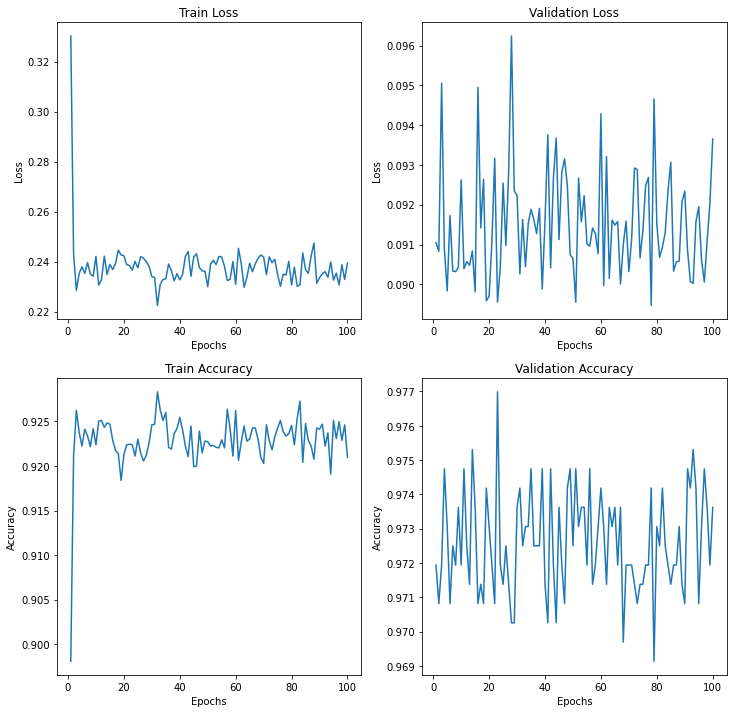

In [4]:
def load_model(model_path, class_num, device):
    model = build_model(class_num, device)
    model.load_state_dict(torch.load(model_path))
    return model


def plot_history(history_path):
    with open(history_path, 'r') as f:
        history = json.load(f)
    
    n = len(history['train_loss'])
    x = [i for i in range(1, n + 1)]
    
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 2, 1)
    plt.plot(x, history['train_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train Loss')
    plt.subplot(2, 2, 2)
    plt.plot(x, history['val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.subplot(2, 2, 3)
    plt.plot(x, history['train_acc'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train Accuracy')
    plt.subplot(2, 2, 4)
    plt.plot(x, history['val_acc'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.show()


model = load_model('/home/g1143790438/Model_History/model.h5', 13, device)
plot_history('/home/g1143790438/Model_History/history.json')

In [6]:
test_model(model, dataloaders['test'], dataset_sizes['test'], batch_size, criterion, device)

  0%|          | 0/28 [00:00<?, ?it/s]

Loss on test dataset: 0.1445, accuracy on test dataset: 0.9607
